# 시맨틱 세그멘테이션 데이터셋

데이터 출처: http://www.cvlibs.net/datasets/kitti/eval_semantics.php  



### **1. 데이터 가져오기 (KITTI 데이터셋의 세그멘테이션 데이터)**  

 mkdir -p ~/aiffel/semantic_segmentation/data  
 ln -s  ~/data/* ~/aiffel/semantic_segmentation/data/
 
 
 
### **2. 데이터 로더 만들기 + augmentation 적용하기 (albumentations)**

(이때 데이터 로더에 augmentation 을 적용해 봅시다. 오늘은 파이썬에서 많이 사용되는 albumentations을 사용해 보겠습니다. 하지만 Augmentation의 경우 imgaug 등 다른 라이브러리를 활용하셔도 됩니다.)

 pip list | grep albumentations

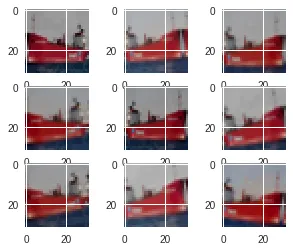  
(albumentation samples : https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)

### 라이브러리 로드

In [54]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


### Albumentation 사용하기

In [55]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

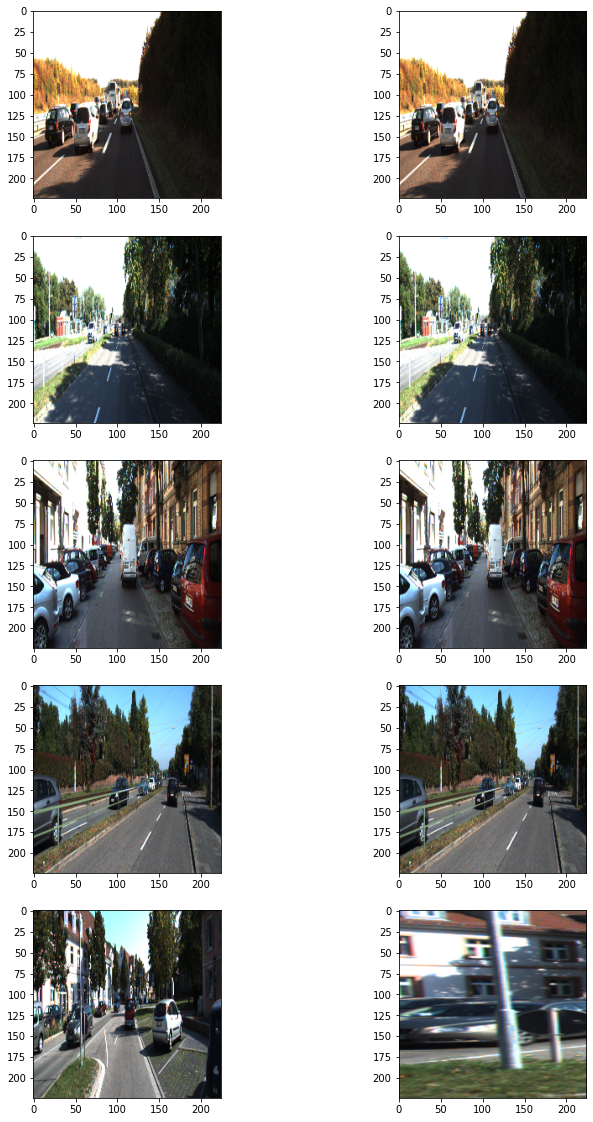

In [56]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

### 데이터셋 구성  

tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터 구성하기

In [57]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1    # 도로 영역 1, 나머지 0
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [58]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [59]:
test_generator

### 시맨틱 세그멘테이션 모델 구조 만들기

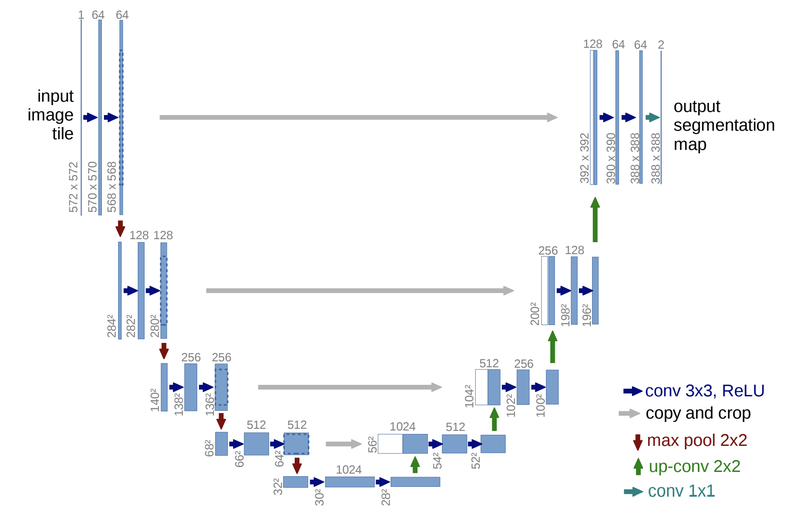

In [60]:
import tensorflow as tf
from tensorflow.keras import layers

def build_model(input_shape=(224, 224, 3)):
    # 입력
    inputs = tf.keras.Input(shape=input_shape)
    
    # 인코더(다운샘플링) 부분
    x1 = ConvBlock(inputs, 64)
    x2 = MaxPoolingBlock(x1)
    
    x3 = ConvBlock(x2, 128)
    x4 = MaxPoolingBlock(x3)
    
    x5 = ConvBlock(x4, 256)
    x6 = MaxPoolingBlock(x5)
    
    x7 = ConvBlock(x6, 512)
    x8 = MaxPoolingBlock(x7)
    
    x9 = ConvBlock(x8, 1024)
    
    # 디코더(업샘플링) 부분
    x10 = UpConvBlock(x9, 512)
    x10 = ConcatBlock(x7, x10)  # 스킵 연결
    x11 = ConvBlock(x10, 512)
    
    x12 = UpConvBlock(x11, 256)
    x12 = ConcatBlock(x5, x12)  # 스킵 연결
    x13 = ConvBlock(x12, 256)
    
    x14 = UpConvBlock(x13, 128)
    x14 = ConcatBlock(x3, x14)  # 스킵 연결
    x15 = ConvBlock(x14, 128)
    
    x16 = UpConvBlock(x15, 64)
    x16 = ConcatBlock(x1, x16)  # 스킵 연결
    x17 = ConvBlock(x16, 64)
    
    # 출력
    # 논문에서는 filters=2이지만 sigmoid 처리를 위해 1로 변경
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x17)

    # 모델 생성
    model = tf.keras.Model(inputs, outputs)
    return model

# Convolutional Block
# 논문과 다르게 입출력 이미지 크기를 맞추기 위해 padding='same'으로 변경하여 학습
def ConvBlock(input, filters=64):
    # padding='valid'를 사용하여 필터 적용
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(input)
    x = Dropout(0.5) (x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5) (x)
    return x

# MaxPooling Block
def MaxPoolingBlock(input):
    x = tf.keras.layers.MaxPool2D((2, 2))(input)
    return x

# UpConvolution Block (Conv2DTranspose)
def UpConvBlock(input, filters=64):
    # Conv2DTranspose로 업샘플링
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(input)
    return x

# Concat Block
def ConcatBlock(x1, x2):
    # x1의 크기와 x2의 크기를 맞추기 위해 resize 적용
    x1_resized = tf.image.resize(x1, size=(x2.shape[1], x2.shape[2]))  # x1의 크기에 맞춰 리사이즈
    x = tf.keras.layers.Concatenate(axis=-1)([x1_resized, x2])
    return x


In [61]:
model = build_model()

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 224, 224, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
dropout_54 (Dropout)            (None, 224, 224, 64) 0           conv2d_114[0][0]                 
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 224, 224, 64) 36928       dropout_54[0][0]                 
____________________________________________________________________________________________

### 모델 학습하기

In [63]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_train3.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=10,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/10
11/11 [==============================] - 10s 732ms/step - loss: 0.6878 - val_loss: 0.6765
Epoch 2/10
11/11 [==============================] - 8s 711ms/step - loss: 0.6433 - val_loss: 0.5663
Epoch 3/10
11/11 [==============================] - 8s 701ms/step - loss: 0.2503 - val_loss: 0.2027
Epoch 4/10
11/11 [==============================] - 8s 691ms/step - loss: 0.2487 - val_loss: 0.2515
Epoch 5/10
11/11 [==============================] - 8s 692ms/step - loss: 0.2194 - val_loss: 0.1865
Epoch 6/10
11/11 [==============================] - 8s 705ms/step - loss: 0.1001 - val_loss: 0.0435
Epoch 7/10
11/11 [==============================] - 8s 723ms/step - loss: 0.0369 - val_loss: 0.0455
Epoch 8/10
11/11 [==============================] - 8s 735ms/step - loss: 0.0417 - val_loss: 0.0978
Epoch 9/10
11/11 [==============================] - 8s 740ms/step - loss: 0.0408 - val_loss: 0.0547
Epoch 10/10
11/11 [==============================] - 8s 715ms/step - loss: 0.0361 - val_loss: 0.041

### 시맨틱 세그멘테이션 모델 시각화

In [16]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path)

이미지 오버레이 하기  
- PIL 패키지의 Image.blend 사용

In [36]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

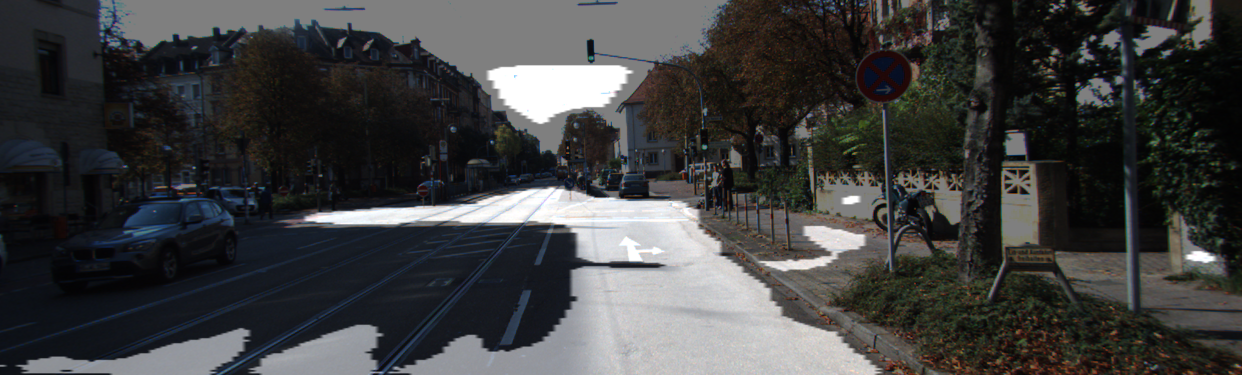

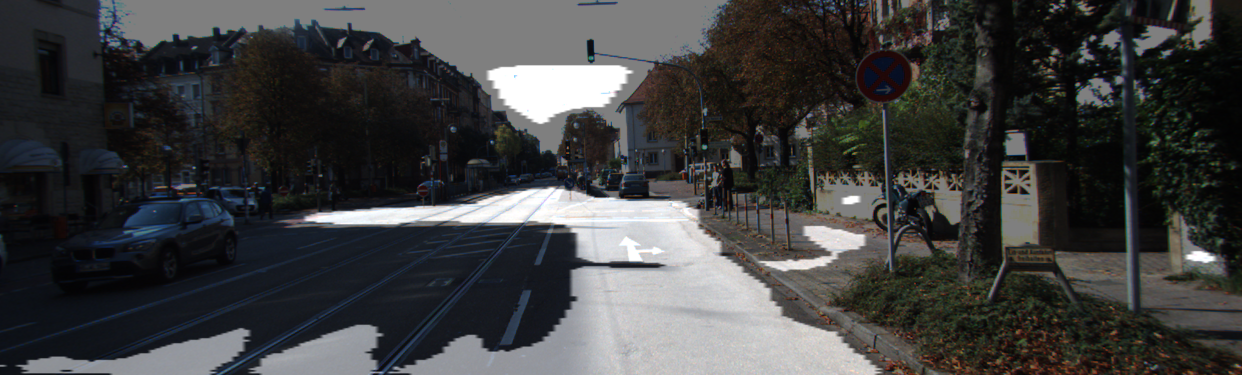

In [20]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

IoU 계산하기

In [21]:
def calculate_iou_score(target, prediction):
    """
    target: 실제 segmentation mask (0과 1로 된 2D 배열)
    prediction: 예측된 segmentation mask (0과 1로 된 2D 배열)
    """
    # target과 prediction을 float32로 변환
    target = tf.cast(target, tf.float32)
    prediction = tf.cast(prediction, tf.float32)
    
    # 교집합 계산: 예측값과 실제값에서 1로 일치하는 부분
    intersection = tf.reduce_sum(target * prediction)
    
    # 합집합 계산: 예측값 또는 실제값에서 1로 표시된 부분의 합
    union = tf.reduce_sum(target) + tf.reduce_sum(prediction) - intersection
    
    # IoU 계산
    iou_score = intersection / union
    print('IoU : %f' % iou_score.numpy())  # IoU 점수 출력
    return iou_score.numpy()  # float 값 반환


In [39]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

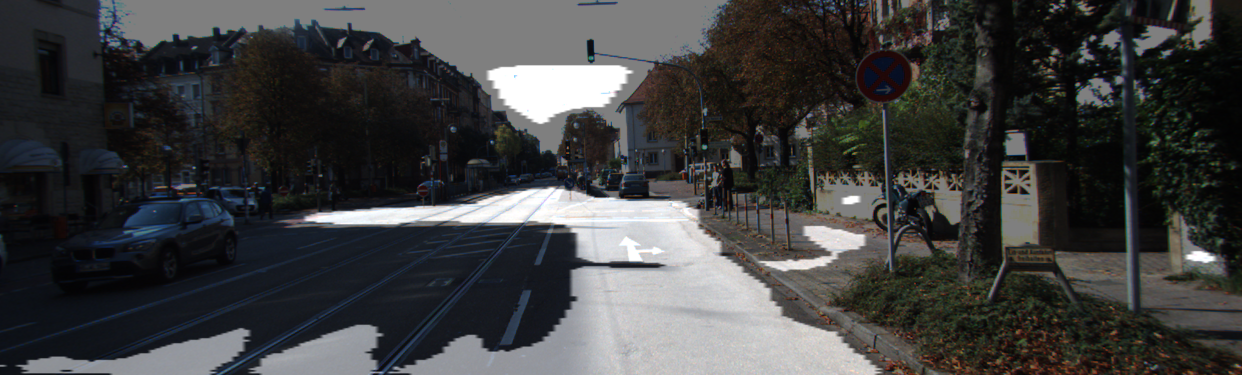

IoU : 0.419641


0.4196409

In [23]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

학습된 모델 기반으로 훈련하기

In [27]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_train2.h5'

load_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
loaded_model = tf.keras.models.load_model(load_model_path)

loaded_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history = loaded_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=10,
 )

loaded_model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/10
11/11 [==============================] - 14s 794ms/step - loss: 0.0191 - val_loss: 0.0205
Epoch 2/10
11/11 [==============================] - 9s 778ms/step - loss: 0.0151 - val_loss: 0.0220
Epoch 3/10
11/11 [==============================] - 9s 788ms/step - loss: 0.0172 - val_loss: 0.0201
Epoch 4/10
11/11 [==============================] - 9s 792ms/step - loss: 0.0182 - val_loss: 0.0222
Epoch 5/10
11/11 [==============================] - 9s 809ms/step - loss: 0.0169 - val_loss: 0.0218
Epoch 6/10
11/11 [==============================] - 9s 819ms/step - loss: 0.0147 - val_loss: 0.0205
Epoch 7/10
11/11 [==============================] - 9s 808ms/step - loss: 0.0139 - val_loss: 0.0204
Epoch 8/10
11/11 [==============================] - 9s 796ms/step - loss: 0.0144 - val_loss: 0.0461
Epoch 9/10
11/11 [==============================] - 9s 788ms/step - loss: 0.0156 - val_loss: 0.0197
Epoch 10/10
11/11 [==============================] - 9s 785ms/step - loss: 0.0152 - val_loss: 0.018

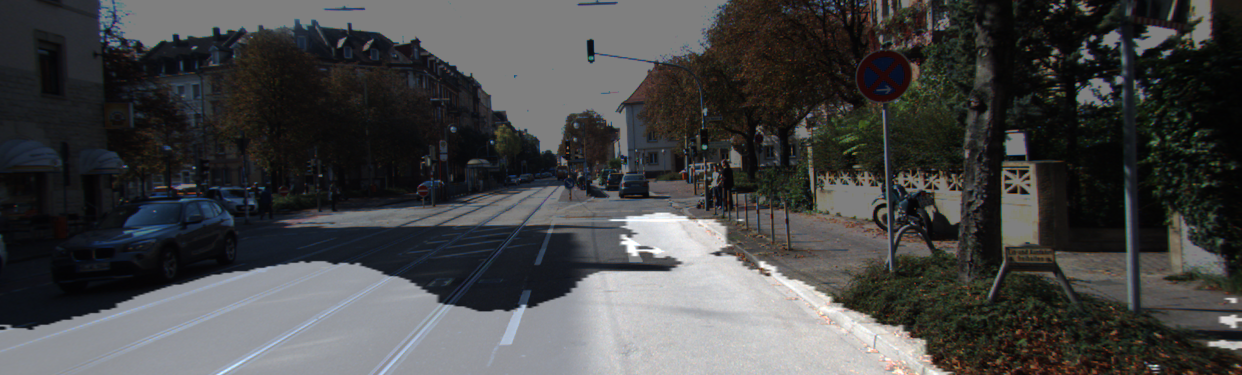

IoU : 0.639681


0.639681

In [41]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 

output, prediction, target = get_output(
     loaded_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)